## [실습7] Object Detection - Yolo v5



### 학습 목표
---
- Yolo v5를 활용한 Object Detection 딥러닝 모델을 학습시키기
- Object Detection을 수행하기 위한 데이터셋 이해부터 Process를 경험하기
- 마스크 착용 / 미착용을 찾아내는 모형을 직접 만들어보기
---

### 0. Colab 런타임유형 변경하기
본 실습은 학습속도 향상을 위해 GPU 자원을 활용합니다.


### 1. 필요한 라이브러리 설치 및 업데이트

In [ ]:
# colba pyyaml이 기본 3.13으로 셋업되어 있으나, 우린 5.0 이상을 활용하기 위해 업데이트 합니다.
!pip install pyyaml --upgrade

     |████████████████████████████████| 596 kB 9.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# 필요한 라이브러리 불러오기
import yaml                        # yaml 파일 수정에 활용
import zipfile                     # zip 파일 수정에 활용
from glob import glob              # 이미지 읽어들이는데 활용
from IPython.display import Image  # 주피터 환경에서 Image 확인에 활용
from requests import get           # to make GET request
import os                          # 파일 위치 특정지을때 활용

### 2. 데이터셋 불러오기

In [ ]:
# roboflow.zip 데이터 다운로드
# 다운로드 링크는 roboflow에서 생성하여 작업
url = """ Your Answer """
file_name = 'roboflow.zip'

def download(url, file_name):
    with open(file_name, "wb") as file:   # open in binary mode
        response = get(url)               # get request
        file.write(response.content)      # write to file 
            
download(url, file_name)

<- 좌측 세션 저장소에 roboflow.zip 파일 생성을 확인할 수 있습니다.

In [ ]:
# roboflow.zip 파일 unzip (압축 해제)
try:
    with zipfile.ZipFile(file_name) as zf:
        zf.extractall()
        print("uncompress success")

except:
    print("uncompress fail")

uncompress success


<- 좌측 세션 저장소에 데이터셋이 생성된 것을 확인할 수 있습니다.

In [ ]:
# roboflow.zip 파일 삭제
!rm roboflow.zip

<- 좌측 세션 저장소에 roboflow.zip 파일이 삭제된 것을 확인할 수 있습니다.

### 3. yaml 파일 수정하기

yaml은 데이터의 포맷에 대한 규칙의 한 종류입니다. <br/>
본 실습에서는 이 데이터셋은 어떤 데이터들이 어떻게 존재하는지에 대한 설명서 같은 것이라 이해해도 됩니다.<br/>
Xml, Json 등 다양한 포맷이 있는데, yaml은 그 가독성 때문에 많이 활용되고 있습니다.

In [ ]:
!pwd

/content


In [ ]:
!ls

data.yaml	    README.roboflow.txt  test	valid
README.dataset.txt  sample_data		 train


In [ ]:
!cat data.yaml

train: ../train/images
val: ../valid/images

nc: 2
names: ['mask', 'no-mask']

yaml 파일을 확인해보니, <br/>
train과 validation 데이터셋의 위치를 알려주고 있고 <br/>
class의 종류가 2개라는 정보와 <br/>
클래스들의 이름이 mask와 no-mask 라는 정보를 주고 있습니다. <br/> <br/>
음.. 이것 만으론 좀 부족한데요...

In [ ]:
# glob을 활용해 이미지 안에 .jpg 파일이 얼마나 있는지 확인해 보겠습니다.

train_img_list = glob('/content/train/images/*.jpg')
val_img_list = glob('/content/valid/images/*.jpg')
test_img_list = glob('/content/test/images/*.jpg')

print(len(train_img_list), len(val_img_list), len(test_img_list))

105 29 15


train엔 105개, valid에 29개, test에 15개 img파일들이 있음을 알 수 있습니다. <br/>

In [ ]:
# train과 valid 파일명을 각각 .txt 파일로 생성해 보겠습니다.
with open('/content/train.txt', 'w') as f:
      f.write('\n'.join(train_img_list) + '\n')

with open('/content/val.txt', 'w') as f:
      f.write('\n'.join(val_img_list) + '\n')

<- 좌측 세션 저장소에 train.txt, val.txt 파일들이 생성된 것을 확인할 수 있습니다.

In [ ]:
# yaml 파일 수정
with open('/content/data.yaml', 'r') as f:
    data = yaml.full_load(f)

print('[수정 전]')
print(data)

data['train'] = """ Your Answer """
data['val'] = """ Your Answer """

with open('/content/data.yaml', 'w') as f:
    yaml.dump(data, f)

print()
print('[수정 후]')
print(data)

[수정 전]
{'train': '../train/images', 'val': '../valid/images', 'nc': 2, 'names': ['mask', 'no-mask']}

[수정 후]
{'train': '/content/train.txt', 'val': '/content/val.txt', 'nc': 2, 'names': ['mask', 'no-mask']}


In [ ]:
# 수정된 data.yaml 확인
!cat data.yaml

names:
- mask
- no-mask
nc: 2
train: /content/train.txt
val: /content/val.txt


yaml 파일에서 train과 validation에 어떤 파일들을 사용할지에 대한 정보를 txt 파일로 명시해주었습니다.

### 4. yolov5 설치

In [ ]:
# yolov5 공식 repository를 다운받아 설치합니다.
# https://github.com/ultralytics/yolov5

!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 13049, done.
remote: Total 13049 (delta 0), reused 0 (delta 0), pack-reused 13049
Receiving objects: 100% (13049/13049), 11.97 MiB | 19.90 MiB/s, done.
Resolving deltas: 100% (9070/9070), done.


<- yolov5라는 폴더가 생긴것을 확인 가능합니다.

In [ ]:
# yolov5를 활용하는데 필요한 패키지들을 설치해 줍니다.
%cd yolov5/
!pip install -r requirements.txt

/content/yolov5


### 5. yolov5 모델 학습시키기

yolov5 튜토리얼을 참고하여 모델을 학습시켜보겠습니다.<br/> https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data

In [ ]:
# yolov5 폴더안에 현재 위치해 있는지 확인!
!pwd

/content/yolov5


In [ ]:
!ls

CONTRIBUTING.md  export.py   models	       setup.cfg       utils
data		 hubconf.py  README.md	       train.py        val.py
detect.py	 LICENSE     requirements.txt  tutorial.ipynb


In [ ]:
!python train.py """ Your Answer """

train: weights=yolov5s.pt, cfg=/content/yolov5/models/yolov5s.yaml, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=mask_yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-165-g1a3ecb8 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0

config는 yolov5의 모델 중 어떤 모델을 활용할 것인가인데 <br/>
크기는  x > l > m > s > n 순이며, 성능이 상대적으로 좋아지는 대신 학습에 필요한 리소스(시간, 연산량 등)가 증가합니다.
<br/>
weight는 pretrained 된 웨이트 값을 활용할 것인데, s모델의 weight를 다운받아서 활용하겠다는 뜻 입니다.

### 6. Test 데이터로 확인해보기

In [ ]:
!pwd

/content/yolov5


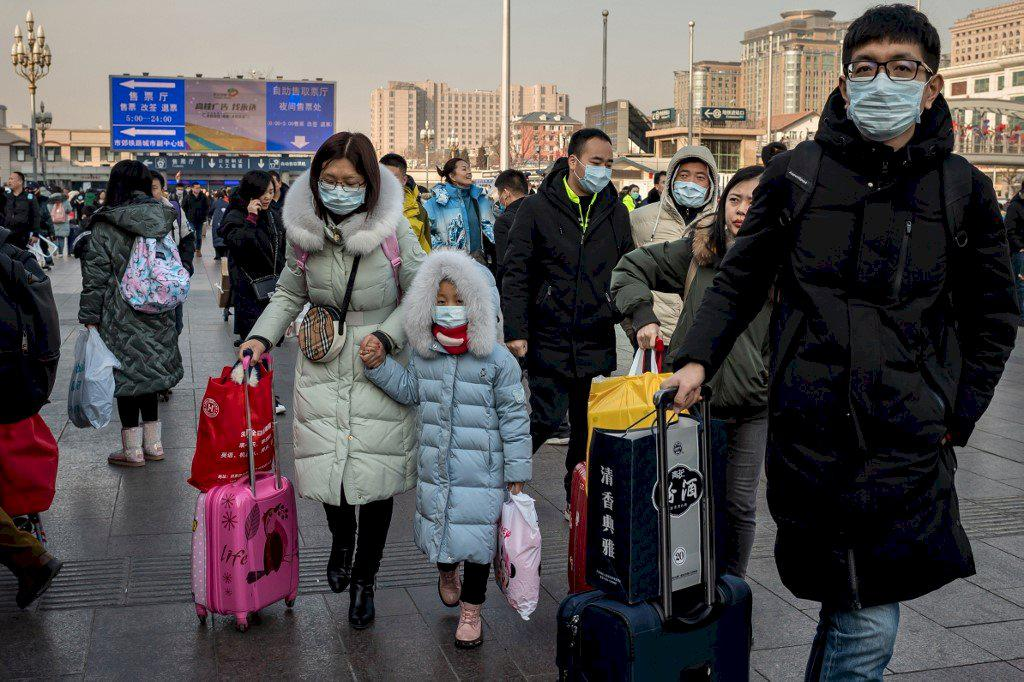

In [ ]:
test_img_path = test_img_list[0]
Image(test_img_path)

In [ ]:
!python detect.py """ Your Answer """


detect: weights=['/content/yolov5/runs/train/mask_yolov5s_results/weights/best.pt'], source=/content/test/images/1579924271_jpg.rf.1fea0f43731fbea2876f63135256004f.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-165-g1a3ecb8 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/test/images/1579924271_jpg.rf.1fea0f43731fbea2876f63135256004f.jpg: 288x416 5 masks, Done. (0.018s)
Speed: 0.3ms pre-process, 17.9ms inference, 1.2ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp


conf값은 모델이 확신하는 정도 기준값 입니다. <br/>
0.6을 값으로 주면, 0.6(60%) 이상의 확신을 하는 대상들을 표기합니다.


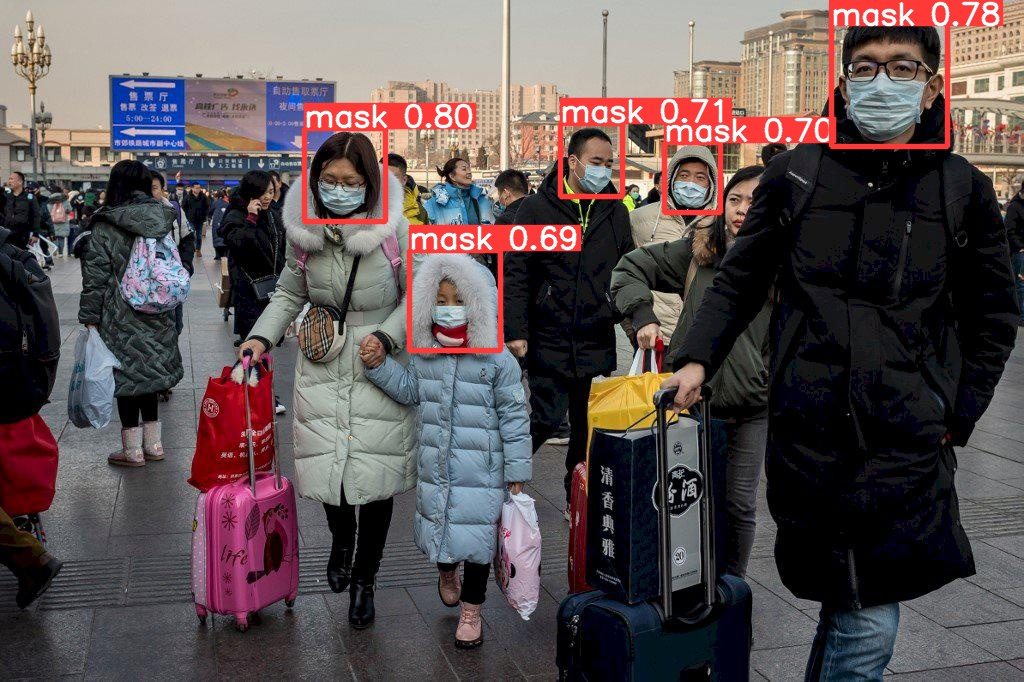

In [ ]:
# 추론 결과 확인
Image(os.path.join('/content/yolov5/runs/detect/exp', os.path.basename(test_img_path)))

### 7. 다수의 이미지 한번에 모델에 추론시키기

In [ ]:
# test용 이미지들 폴더를 param으로 주기
test_imgs_path = '/content/test/images/'

!python detect.py """ Your Answer """

detect: weights=['/content/yolov5/runs/train/mask_yolov5s_results/weights/best.pt'], source=/content/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-165-g1a3ecb8 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/15 /content/test/images/0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg: 224x416 2 masks, Done. (0.014s)
image 2/15 /content/test/images/1224331650_g_400-w_g_jpg.rf.483a35a2395bf48e96783587a59fe876.jpg: 416x416 4 masks, Done. (0.010s)
image 3/15 /content/test/images/126202-untitled-design-

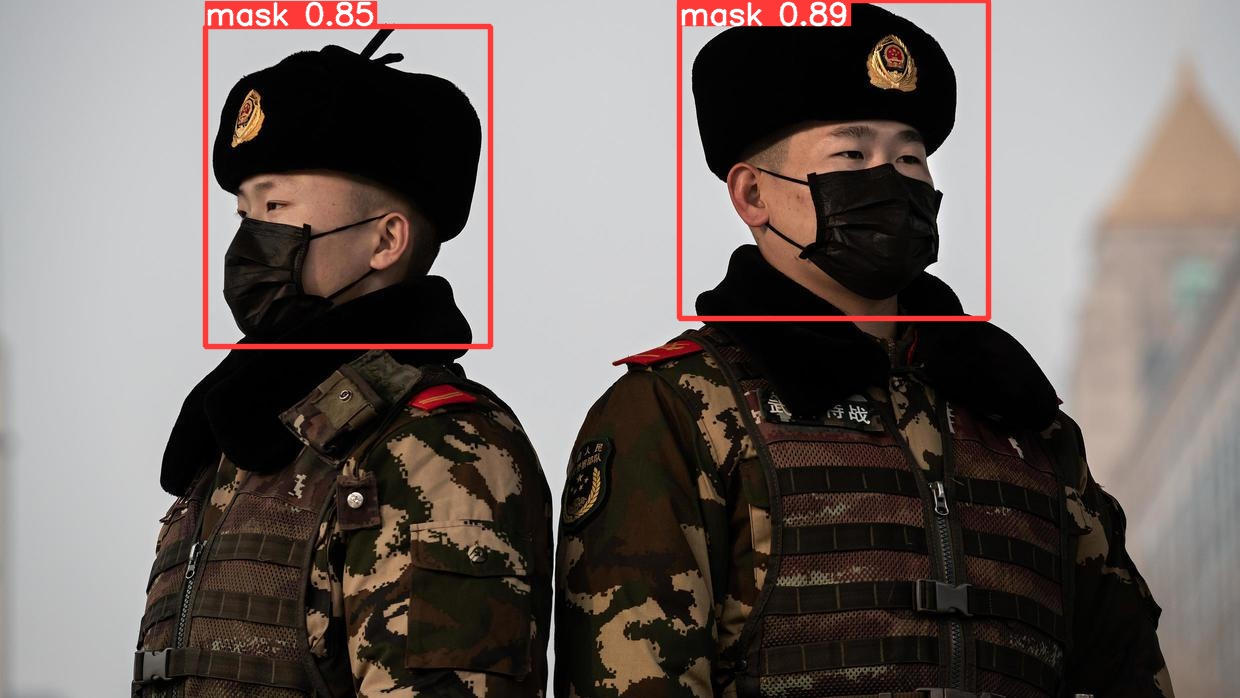

In [ ]:
Image(os.path.join('/content/yolov5/runs/detect/exp2', os.path.basename(test_img_list[2])))

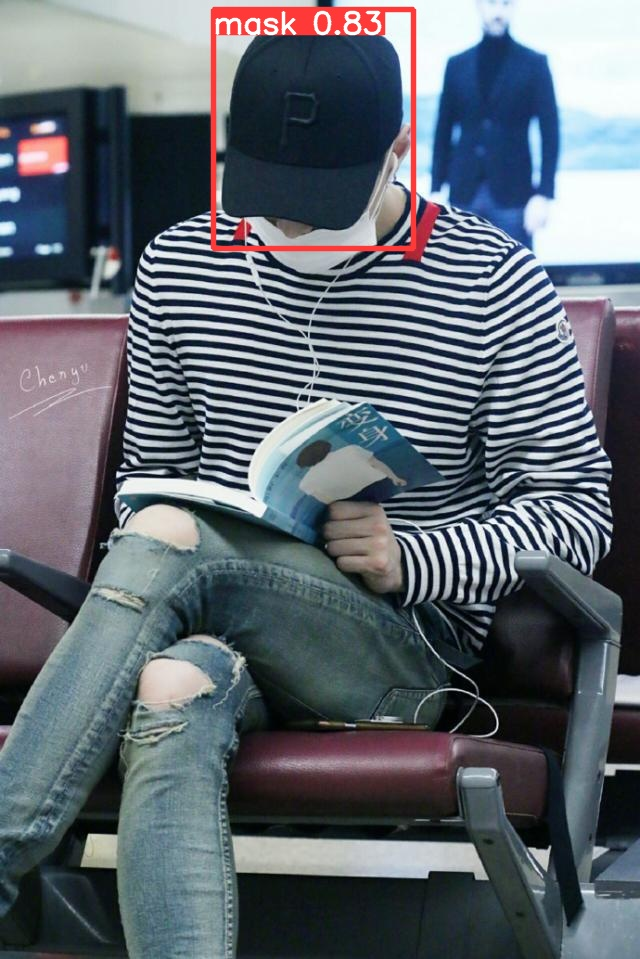

In [ ]:
Image(os.path.join('/content/yolov5/runs/detect/exp2', os.path.basename(test_img_list[7])))

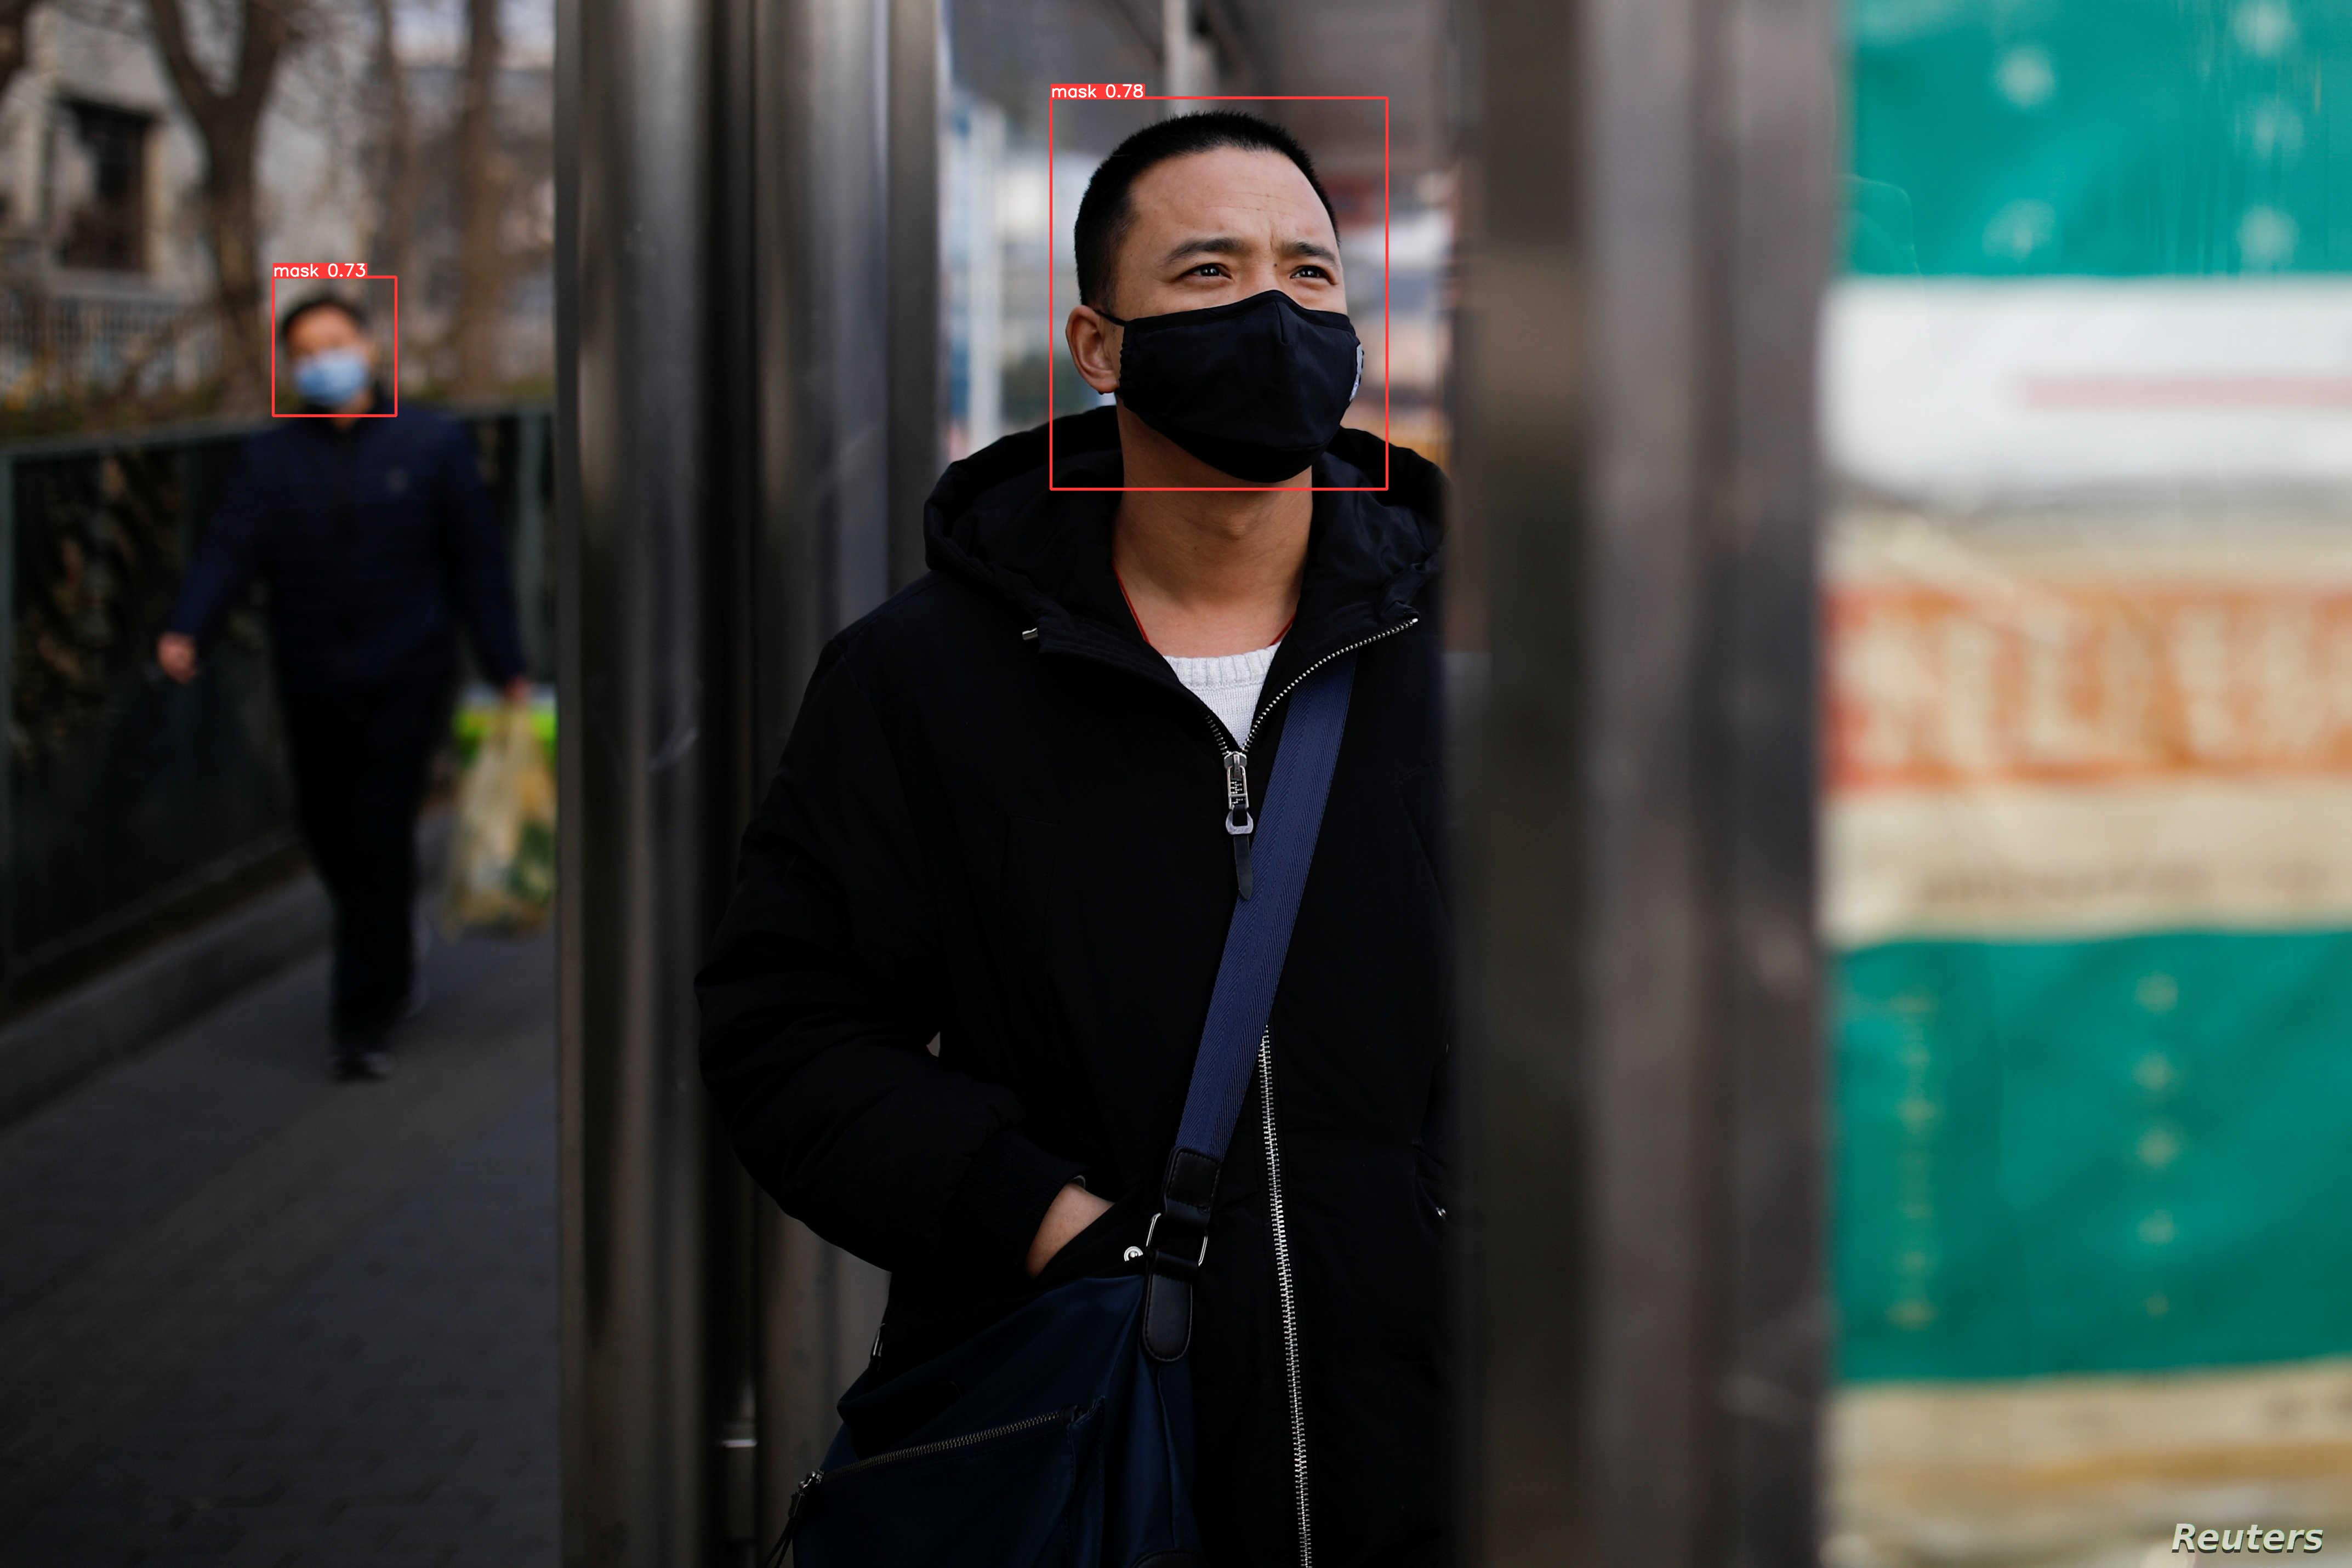

In [ ]:
Image(os.path.join('/content/yolov5/runs/detect/exp2', os.path.basename(test_img_list[12])))